In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Dataset, Reader, NormalPredictor, KNNBasic, KNNWithZScore, KNNWithMeans, KNNWithZScore, SVD
from surprise.model_selection import train_test_split, cross_validate
from collections import defaultdict
from surprise import accuracy
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import spacy

In [2]:
data = []
with open('yelp/review.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

df_reviews = pd.DataFrame(data)
df_reviews

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
6990275,H0RIamZu0B0Ei0P4aeh3sQ,qskILQ3k0I_qcCMI-k6_QQ,jals67o91gcrD4DC81Vk6w,5.0,1,2,1,Latest addition to services from ICCU is Apple...,2014-12-17 21:45:20
6990276,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5.0,2,1,2,"This spot offers a great, affordable east week...",2021-03-31 16:55:10
6990277,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4.0,1,0,0,This Home Depot won me over when I needed to g...,2019-12-30 03:56:30
6990278,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5.0,1,0,0,For when I'm feeling like ignoring my calorie-...,2022-01-19 18:59:27


In [3]:
data = []
with open('yelp/business.json', 'r') as file:
    for line in file:
        data.append(json.loads(line))

df_business = pd.DataFrame(data)
df_business

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,AB,T6J 5H2,53.468419,-113.492054,3.0,13,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas","{'Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,TN,37204,36.115118,-86.766925,4.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,IN,46250,39.908707,-86.065088,3.5,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",None
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,IL,62025,38.782351,-89.950558,4.0,24,1,"{'BusinessParking': '{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."


In [4]:
# Filtering the data just for Restaurants in Nashville
df_nashville = df_reviews.merge(df_business, how='left', on='business_id')
df_nashville = df_nashville[(df_nashville['city'] == 'Nashville') & (df_nashville['categories'].str.contains('Restaurants', na=False))]
df_nashville.reset_index(drop=True, inplace=True)
df_nashville

,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,stars_y,review_count,is_open,attributes,categories,hours
0,elqRpX9T3YwL07uLNtN3Bg,-sryo4gDYxbZ1T5Bz4l5Bw,ltBBYdNzkeKdCNPDAsxwAA,2.0,0,0,0,I at least have to give this restaurant two st...,2015-02-02 04:29:13,Tavern,...,TN,37203,36.150900,-86.797012,4.0,1222,1,"{'BikeParking': 'True', 'Alcohol': 'u'full_bar...","Cocktail Bars, Nightlife, Gastropubs, Sports B...","{'Monday': '0:0-0:0', 'Wednesday': '10:0-22:0'..."
1,E9AB7V4z8xrt2uPF7T55FQ,iYY5Ii1LGpZCpXFkHlMefw,Zx7n8mdt8OzLRXVzolXNhQ,5.0,0,0,0,Amazing biscuits and (fill in the blank). Grea...,2018-04-27 23:03:21,Milk and Honey Nashville,...,TN,37203,36.154702,-86.784541,4.0,1725,1,"{'WheelchairAccessible': 'True', 'RestaurantsP...","American (New), Restaurants, American (Traditi...","{'Monday': '0:0-0:0', 'Thursday': '6:30-15:0',..."
2,qGQvUHmC02PAZW3H1WTIfw,RRTQpg8hutdimzAYuP_Hbw,eaJCpC6IhYphj7bwCDHTwQ,5.0,0,0,0,Stopped by after a Sunday morning walk in the ...,2015-08-30 13:41:47,Three Brothers Coffee,...,TN,37203,36.144808,-86.812266,4.5,249,1,"{'RestaurantsTableService': 'False', 'Restaura...","Bagels, Sporting Goods, Outdoor Gear, Coffee &...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-19:0', '..."
3,67cGcRrS0jTvB8p7rpaPew,8YSxVaD203mE_9FR4nCEVA,oQ5CPRt0R3AzFvcjNOqB1w,3.0,1,0,0,Honestly the food doesn't knock my socks off b...,2016-01-17 13:26:19,Edley's Bar-B-Que - 12 South,...,TN,37204,36.122973,-86.789782,4.0,1114,1,"{'RestaurantsGoodForGroups': 'True', 'GoodForK...","Barbeque, Restaurants, Dive Bars, Cocktail Bar...","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
4,DOeEDBfsrNph0ktNkYYFnQ,qVYilGRmY6uemAy_tDpfuA,9OtFX3YzG5keaUMOWU1imA,5.0,4,0,0,Man. This place is nice. The bartender was awe...,2014-05-26 01:56:19,Champions,...,TN,37214,36.146207,-86.693053,4.0,73,0,"{'BikeParking': 'True', 'RestaurantsReservatio...","American (Traditional), Bars, American (New), ...","{'Monday': '6:0-1:0', 'Tuesday': '6:0-1:0', 'W..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325721,KKZDkIuPXXE8C0aPmWmurQ,ek0l1feRZO1PU4uzR1oBWA,yX0P0_JV1imBE46I1ZMEaA,2.0,0,0,0,Slow slowwwww sllllooooowwwww service. And the...,2021-10-31 14:59:07,Panera Bread,...,TN,37204,36.106011,-86.763501,2.5,77,1,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Salad, Bagels, Soup, Breakfast & Brunch, Resta...","{'Monday': '6:0-21:0', 'Tuesday': '6:0-21:0', ..."
325722,VpsDpnqS0hL2oi8jf0VchQ,lrO6hCPYV-j3IAxNSMCW2g,1b5mnK8bMnnju_cvU65GqQ,4.0,0,0,0,Nice place to eat. It was packed. You may wa...,2021-11-15 18:02:06,Biscuit Love: Gulch,...,TN,37203,36.153050,-86.783231,4.0,4207,1,"{'NoiseLevel': ''average'', 'HasTV': 'False', ...","Burgers, American (Traditional), Breakfast & B...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-15:0', '..."
325723,3EJzX99Yx4fm25YJ35p1-w,yVO4zAHlXDKN5oXiM-iI0w,yZHiutcbym-xLGkmFhP-9A,1.0,0,0,0,We were stranded in Nashville for an extra day...,2022-01-03 17:11:15,Frothy Monkey,...,TN,37204,36.124625,-86.789794,4.0,852,1,"{'RestaurantsReservations': 'False', 'Restaura...","Food, Coffee & Tea, American (New), Sandwiches...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
325724,1ryZLb9pSBz0y66tHB-rfw,XJTO9x78TgWE94cmXqNduA,c3QxX3toWdqJnKQmmIliRQ,1.0,1,2,0,"The supper club is ridiculously expensive. So,...",2021-11-29 18:26:40,Honky Tonk - The Twelve Thirty Club,...,TN,37203,36.160630,-86.778829,4.0,110,1,"{'HasTV': 'True', 'OutdoorSeating': 'True', 'R...","American (Traditional), Restaurants, Cocktail ...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-0:0', '..."


In [5]:
df_reviews_text = df_nashville['text']
df_reviews_text

0         I at least have to give this restaurant two st...
1         Amazing biscuits and (fill in the blank). Grea...
2         Stopped by after a Sunday morning walk in the ...
3         Honestly the food doesn't knock my socks off b...
4         Man. This place is nice. The bartender was awe...
                                ...                        
325721    Slow slowwwww sllllooooowwwww service. And the...
325722    Nice place to eat.  It was packed.  You may wa...
325723    We were stranded in Nashville for an extra day...
325724    The supper club is ridiculously expensive. So,...
325725    Located in the 'Walking District' in Nashville...
Name: text, Length: 325726, dtype: object

In [19]:
print(f'Number of nulls: {df_reviews_text.isnull().sum()}')

Number of nulls: 0


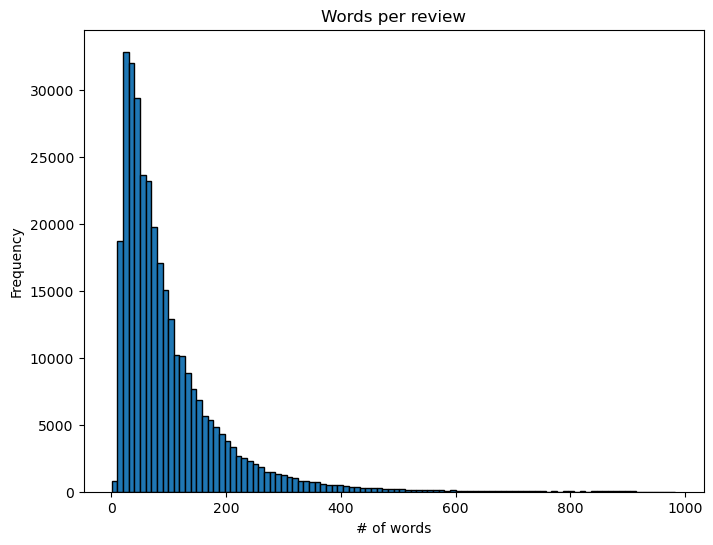

In [20]:
words = df_reviews_text.apply(lambda x: len(x.split()))
plt.figure(figsize=(8, 6))
plt.hist(words, bins=100, edgecolor='black')
plt.title('Words per review')
plt.xlabel('# of words')
plt.ylabel('Frequency')
plt.show()

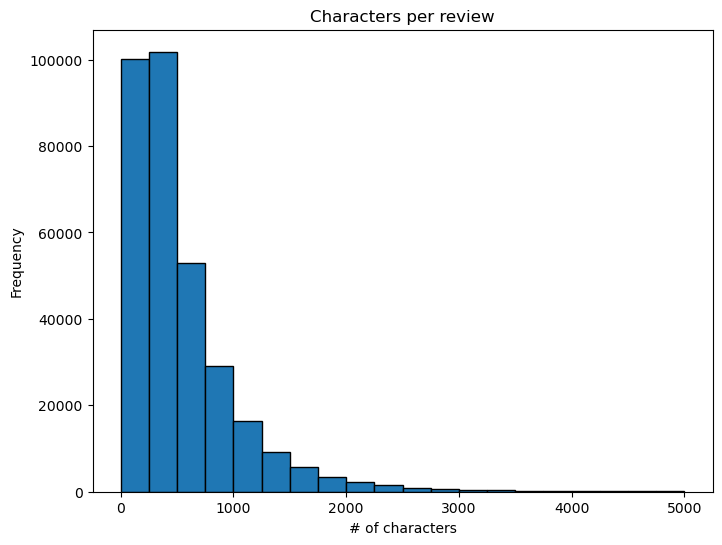

In [21]:
characters = df_reviews_text.str.len()
plt.figure(figsize=(8, 6))
plt.hist(characters, bins=20, edgecolor='black')
plt.title('Characters per review')
plt.xlabel('# of characters')
plt.ylabel('Frequency')
plt.show()

In [29]:
review_tokens = df_reviews_text.apply(lambda x: word_tokenize(x))
review_tokens

0         [I, at, least, have, to, give, this, restauran...
1         [Amazing, biscuits, and, (, fill, in, the, bla...
2         [Stopped, by, after, a, Sunday, morning, walk,...
3         [Honestly, the, food, does, n't, knock, my, so...
4         [Man, ., This, place, is, nice, ., The, barten...
                                ...                        
325721    [Slow, slowwwww, sllllooooowwwww, service, ., ...
325722    [Nice, place, to, eat, ., It, was, packed, ., ...
325723    [We, were, stranded, in, Nashville, for, an, e...
325724    [The, supper, club, is, ridiculously, expensiv...
325725    [Located, in, the, 'Walking, District, ', in, ...
Name: text, Length: 325726, dtype: object

In [35]:
# initialize the Porter Stemmer
porter = PorterStemmer()

def porter_stemmer(word_list):
    # stem list of words and join
    stemmed_output = ' '.join([porter.stem(w) for w in word_list])

    # tokenize: split the text into words
    stemmed_word_list = word_tokenize(stemmed_output)

    return stemmed_word_list

review_tokens_stemmed = review_tokens.apply(lambda x: porter_stemmer(x))
review_tokens_stemmed

0         [i, at, least, have, to, give, thi, restaur, t...
1         [amaz, biscuit, and, (, fill, in, the, blank, ...
2         [stop, by, after, a, sunday, morn, walk, in, t...
3         [honestli, the, food, doe, n't, knock, my, soc...
4         [man, ., thi, place, is, nice, ., the, bartend...
                                ...                        
325721    [slow, slowwwww, sllllooooowwwww, servic, ., a...
325722    [nice, place, to, eat, ., it, wa, pack, ., you...
325723    [we, were, strand, in, nashvil, for, an, extra...
325724    [the, supper, club, is, ridicul, expens, ., so...
325725    [locat, in, the, 'walk, district, ', in, nashv...
Name: text, Length: 325726, dtype: object

In [ ]:
# Using Spacy's NLP trained pipeline - Takes a lot of time to run
nlp = spacy.load("en_core_web_sm")

review_tokens_spacy = df_reviews_text.apply(lambda x: nlp(x))
review_tokens_spacy

In [ ]:
# Removing stop words - Takes a lot of time to run
def remove_stop(words_list):
    return [word for word in words_list if word not in stopwords.words('english')]
    
review_tokens_stemmed_stop = review_tokens_stemmed.apply(lambda x: remove_stop(x))
review_tokens_stemmed_stop

In [ ]:
# FEATURE ENGINEERING

In [ ]:
# Bag-of-words model
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus).toarray() # corpus is a list of strings of sentences

print(X.shape)

In [ ]:
print(vectorizer.get_feature_names_out())

# Vader

In [7]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [8]:
y_pred = []
for rev in df_reviews_text[:1000]:
    y_pred.append(1 if analyzer.polarity_scores(rev)['compound'] > 0 else 0)

In [19]:
y = df_nashville['stars_x'][:1000].apply(lambda x: 1 if x>3 else 0)
y = list(y)
y

[0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,


In [17]:
y_pred

[1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,


In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(confusion_matrix(y, y_pred))
print('Accuracy: ', accuracy_score(y, y_pred))
print('Precision: ', precision_score(y, y_pred))
print('Recall: ', recall_score(y, y_pred))
print('F1: ', f1_score(y, y_pred))

[[ 95 217]
 [ 10 678]]
Accuracy:  0.773
Precision:  0.7575418994413408
Recall:  0.9854651162790697
F1:  0.8566013897662667
